<a href="https://colab.research.google.com/github/demelere/Text-Classification/blob/master/453_Assignment_3_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [66]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
qualitative_colors=sns.set_palette("Set3",10)
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# word vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# model pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Data input and cleaning

In [0]:
df = pd.read_csv('bbc-text.csv')

SHAPE OF DATASET:  (2225, 2) 

COLUMNS IN DATASET:  Index(['category', 'text'], dtype='object') 

CATEGORIES:  ['tech' 'business' 'sport' 'entertainment' 'politics'] 

DATA SAMPLE: 

       category                                               text
384   politics  drive to  save  festive holidays efforts are b...
1983     sport  officials respond in court row australian tenn...
985      sport  cup holders man utd visit everton holders manc...
1386     sport  adriano s chelsea link rejected adriano s agen...
1294     sport  o driscoll/gregan lead aid stars ireland s bri... 


NUMBER OF SAMPLES IN EACH CATEGORY: 



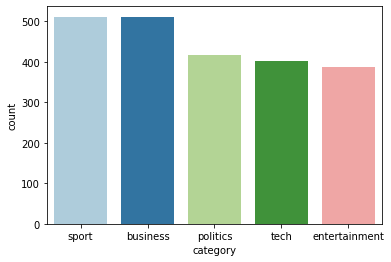

In [68]:
# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.category.unique(), '\n\nDATA SAMPLE: \n\n', df.sample(n=5, random_state=0), '\n\n')

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(x=df.category, order=df.category.value_counts().index,color=sns.set_palette("Paired"))

In [0]:
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [70]:
# DATA CLEANING
print('Data cleaning in progress...')

# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



# 3. Model training and evaluation

## 3.1 Classification using Word2Vec Vectors

In [0]:
vec_model = Word2Vec(df['text_clean'])
w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

In [0]:
clf_models = {
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Logistic Regression': { },
    'Gradient Boosting': { 'min_samples_split': [2, 5] },
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Perceptron': { 'activation': ['tanh', 'relu'] },
}

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))

Logistic Regression :
Accuracy: 0.326 	Precision: 0.130 	Recall: 0.278 		F1: 0.177

Gradient Boosting :
Accuracy: 0.472 	Precision: 0.473 	Recall: 0.461 		F1: 0.459

Naive Bayes :
Accuracy: 0.353 	Precision: 0.413 	Recall: 0.336 		F1: 0.325

SVC :
Accuracy: 0.321 	Precision: 0.129 	Recall: 0.274 		F1: 0.175

Perceptron :
Accuracy: 0.351 	Precision: 0.142 	Recall: 0.298 		F1: 0.191



## 3.2 Classification using TF-IDF Vectors

In [0]:
# Vectorize training and testing data
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

In [0]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC()
}

params = {
    'Logistic Regression': { },
    'SVC': { 'kernel': ['linear', 'rbf'] }
}

In [82]:
# Encode label categories to numbers
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Logistic Regression : {}
Precision: 0.976 	Recall: 0.974 		F1: 0.975

SVC : {'kernel': 'linear'}
Precision: 0.979 	Recall: 0.981 		F1: 0.980



In [0]:
models = {
    
}

params = {
    
}

In [80]:
# Encode label categories to numbers
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.955 	Recall: 0.958 		F1: 0.955



KeyboardInterrupt: ignored

In [0]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# features = tfidf.fit_transform(df.text).toarray()
# labels = df.category_id
# features.shape

In [0]:
# models = [
#     LogisticRegression(random_state=0),
#     # DecisionTreeClassifier(min_samples_split=[2, 5]),
#     # RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#     # MultinomialNB(),
#     GradientBoostingClassifier(),
#     GaussianNB(),
#     SVC(kernel=['linear', 'rbf']),
#     MLPClassifier(activation=['tanh','relu'])
# ]

# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model in models:
#   model_name = model.__class__.__name__
#   accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#   for fold_idx, accuracy in enumerate(accuracies):
#     entries.append((model_name, fold_idx, accuracy))
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])